### Import data

In [124]:
import pandas as pd
import numpy as np
df = pd.read_csv('../Datasets/academic_performance.csv', header=0)

In [125]:
df['gender'].value_counts()

M    305
F    175
Name: gender, dtype: int64

### Correct typos

In [126]:
newcols = df.columns.values
newcols[0] = "Gender"
newcols[1] = "Nationality"
newcols[2] = "PlaceOfBirth"
newcols[9] = "RaisedHands"
newcols[10] = "VisitedResources"
newcols[14] = "ParentSchoolSatisfaction"
df.columns = newcols

# Discard PlaceOfBirth, as it is redundant with Nationality
df = df.drop(["PlaceOfBirth"], axis = 1)

In [127]:
df["Nationality"] = df['Nationality'].str.replace("KW", "Kuwait")
df["Nationality"] = df['Nationality'].str.replace("lebanon", "Lebanon")
df["Nationality"] = df['Nationality'].str.replace("venzuela", "Venezuela")
df["Nationality"] = df['Nationality'].str.replace("Tunis", "Tunisia")
df["Nationality"] = df['Nationality'].str.replace("Lybia", "Libya")
df["Nationality"] = df['Nationality'].str.replace("lebanon", "Lebanon")

In [128]:
df["StageID"] = df["StageID"].str.replace("lowerlevel", "LowerLevel")
df.Gender = np.where(df.Gender == "M", "Male", "Female")
df.Semester = np.where(df.Semester == "F", "First", "Second")
df.SectionID = "section_" + df.SectionID
df["Relation"] = df["Relation"].str.replace("Mum", "Mother")

In [129]:
# Copy with names for EDA
df.to_csv('../Datasets/originalClean.csv', index=False)

### Change Gender, StageID, GradeID, Semester, Relation, ParentAnswering, ParentSchool, Class, StudentAbsence to numerical values

Codes:

- Gender: 0 Female, 1 Male
- StageID: 0 Lower, 1 Middle, 2 High
- GradeID: 0 - 11
- Semester: 0 First, 1 Second
- Relation: 0 Mother, 1 Father
- ParentAnswering: 0 No, 1 Yes
- ParentSchool: 0 Bad, 1 Good
- Class: 0 L, 1 M, 2 H
- StudentAbsence: 0 Under-7, 1 Above-7

In [130]:
df.Gender = np.where(df.Gender == "Male", 1, 0)
df.StageID = np.where(df.StageID == "LowerLevel", 0,
                      np.where(df.StageID == "MiddleSchool", 1, 2))
df.GradeID = df.GradeID.str[2:].astype(np.int64) - 1
df.Semester = np.where(df.Semester == "First", 0, 1)
df.Relation = np.where(df.Relation == "Father", 1, 0)
df.ParentAnsweringSurvey = np.where(df.ParentAnsweringSurvey == "No", 0, 1)
df.ParentSchoolSatisfaction = np.where(df.ParentSchoolSatisfaction == "Bad", 0, 1)
df.Class = np.where(df.Class == "L", 0,
                    np.where(df.Class == "M", 1, 2))
df.StudentAbsenceDays = np.where(df.StudentAbsenceDays == "Under-7", 0, 1)

### Turn Nationality, SectionID, Topic into dummy variables

In [131]:
col = ["Nationality", "SectionID", "Topic"]

for c in col:
    dummies = []
    dummies.append(pd.get_dummies(df[c]))
    df_dummies = pd.concat(dummies, axis = 1)
    df = pd.concat((df, df_dummies), axis = 1)
    df = df.drop([c], axis = 1)

In [132]:
df.to_csv('../Datasets/academic_onehot.csv', index=False)

In [133]:
corr_matrix = df.corr()

In [134]:
corr_matrix["Gender"].sort_values(ascending=False)

Gender                      1.000000
StudentAbsenceDays          0.209011
Relation                    0.195142
Spanish                     0.158075
Kuwait                      0.100790
Tunisia                     0.093569
Arabic                      0.072642
Math                        0.056212
section_C                   0.052527
Semester                    0.049156
Iran                        0.046264
Iraq                        0.041827
Egypt                       0.040886
Palestine                   0.040784
Venezuela                   0.034610
IT                          0.028631
Morocco                     0.021823
Syria                       0.019934
GradeID                     0.018304
StageID                     0.017793
section_B                   0.017134
Biology                     0.016764
Libya                       0.007305
SaudiArabia                 0.000301
Quran                      -0.020267
ParentAnsweringSurvey      -0.022359
History                    -0.023818
G

In [135]:
corr_matrix["Class"].sort_values(ascending=False)

Class                       1.000000
VisitedResources            0.677094
RaisedHands                 0.646298
AnnouncementsView           0.527370
ParentAnsweringSurvey       0.435495
ParentSchoolSatisfaction    0.375901
Discussion                  0.308183
Iraq                        0.177312
Palestine                   0.132213
Biology                     0.127294
Semester                    0.126239
Lebanon                     0.097483
SaudiArabia                 0.086672
StageID                     0.083997
GradeID                     0.071654
Geology                     0.067096
Jordan                      0.061718
Venezuela                   0.059179
English                     0.053453
USA                         0.045440
Science                     0.039827
section_A                   0.023534
Quran                       0.017481
French                      0.016026
Chemistry                   0.015975
History                     0.005803
Arabic                      0.001325
s

Females are more likely to have absent days and study Spanish, and less likely to be in a high Class, Visit Resources, Raise hands, Discuss.

## Prepare for ML / Hyper-param tuning

In [138]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split data in train / tet
train, test = train_test_split(df, test_size=0.10, random_state=42)

# Generate balanced set by undersampling males to match the number of females
num_fem = train.Gender.value_counts()[0]
train_male_sample = train[train.Gender == 1].sample(num_fem)
train_under = train[train.Gender == 0]
train_under = pd.concat([train_under, train_male_sample])
    
# Unbalanced train set
X = train.drop(["Class"], axis=1).values
y = train["Class"].values

# Balanced train set using SMOTE
X_preS = train.drop(["Gender"], axis=1).values
y_preS = train['Gender'].values
X_smote, y_smote = SMOTE().fit_sample(X_preS, y_preS)
    
# Balanced train set using undersampling
X_under = train_under.drop(["Class"], axis=1).values
y_under = train_under["Class"].values

# Test sets
X_test = test.drop(['Class'], axis=1).values
y_test = test['Class'].values

In [139]:
np.unique(y_smote, return_counts=True)

(array([0, 1]), array([275, 275]))

In [40]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

In [41]:
from sklearn.metrics import accuracy_score

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

bbase_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
bbase_model.fit(X, y)
bbase_accuracy = evaluate(bbase_model, X_test, y_test)

Model Performance
Accuracy = 0.75%.


In [42]:
sbase_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
sbase_model.fit(X_smote, y_smote)
sbase_accuracy = evaluate(sbase_model, X_test, y_test)

Model Performance
Accuracy = 0.44%.


In [43]:
ubase_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
ubase_model.fit(X_under, y_under)
ubase_accuracy = evaluate(ubase_model, X_test, y_test)

Model Performance
Accuracy = 0.75%.


In [44]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': range(20, 520, 20)
}
# Create a based model
rf_base = RandomForestClassifier()
rf_smote = RandomForestClassifier()
rf_under = RandomForestClassifier()

# Instantiate the grid search model
bgrid_search = GridSearchCV(estimator = rf_base, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose=1)
sgrid_search = GridSearchCV(estimator=rf_smote, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose=1)
ugrid_search = GridSearchCV(estimator = rf_under, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose=1)

In [45]:
bgrid_search.fit(X, y)
bgrid_search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   10.4s finished


{'n_estimators': 260}

In [46]:
bgrid_accuracy = evaluate(bgrid_search, X_test, y_test)

Model Performance
Accuracy = 0.79%.


In [47]:
sgrid_search.fit(X_smote, y_smote)
sgrid_search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   11.3s finished


{'n_estimators': 480}

In [48]:
sgrid_accuracy = evaluate(sgrid_search, X_test, y_test)

Model Performance
Accuracy = 0.46%.


In [49]:
ugrid_search.fit(X_under, y_under)
ugrid_search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    9.9s finished


{'n_estimators': 40}

In [50]:
ugrid_accuracy = evaluate(ugrid_search, X_test, y_test)

Model Performance
Accuracy = 0.75%.


### Our num_estimators will be 320 for base, 420 for smote and 220 for under

In [52]:
from imblearn.over_sampling import SMOTE

# Split data in 480 train-test sets (leave one out)

Xs = []
ys = []
bXs = []
bys = []
bXs_under = []
bys_under = []
rXs = []
rys = []

for i in range(480):
    train_df = df.drop(df.index[i])
    test_df = df.iloc[[i]]
    
    # Generate balanced set by undersampling males to match the number of females
    num_fem = train_df.Gender.value_counts()[0]
    train_male_sample = train_df[train_df.Gender == 1].sample(num_fem)
    train_bal_df = train_df[train_df.Gender == 0]
    train_bal_df = pd.concat([train_bal_df, train_male_sample])
    
    # Unbalanced train set
    X = train_df.drop(["Class"], axis=1).values
    y = train_df["Class"].values

    # Balanced train set using SMOTE
    X_preS = train_df.drop(["Gender"], axis=1).values
    y_preS = train_df["Gender"].values
    bX, by = SMOTE().fit_sample(X_preS, y_preS)
    
    # Balanced train set using undersampling
    bX_under = train_bal_df.drop(["Class"], axis=1).values
    by_under = train_bal_df["Class"].values

    # Reserved test set
    rX = test_df.drop(["Class"], axis=1).values
    ry = test_df["Class"].values
    
    # Build arrays with all different
    Xs.append(X)
    ys.append(y)
    bXs.append(bX)
    bys.append(by)
    bXs_under.append(bX_under)
    bys_under.append(by_under)
    rXs.append(rX)
    rys.append(ry)

## Import ML stuff

In [53]:
# Classifiers
from sklearn.ensemble import RandomForestClassifier as rf

# Get predictions

In [54]:
new_rf_preds = pd.DataFrame(np.zeros((480, 4)))
new_rf_preds.columns = ["base", "smote", "under", "real"]

for i in range(480):
    X = Xs[i]
    y = ys[i]
    bX = bXs[i]
    by = bys[i]
    bX_under = bXs_under[i]
    by_under = bys_under[i]
    rX = rXs[i]
    
    rf_base = rf(n_estimators=320)
    rf_base.fit(X, y)
    rf_smote = rf(n_estimators=420)
    rf_smote.fit(X_smote, y_smote)
    rf_under = rf(n_estimators=220)
    rf_under.fit(X_under, y_under)
    
    new_rf_preds.iloc[i, 0] = rf_base.predict(rX)
    new_rf_preds.iloc[i, 1] = rf_smote.predict(rX)
    new_rf_preds.iloc[i, 2] = rf_under.predict(rX)
    new_rf_preds.iloc[i, 3] = df["Class"][i]

In [55]:
new_rf_preds.to_csv('../Datasets/nnew_rf_predictions.csv', index=False)

Categorical Volatility codes:

0. same predictions, none wrong
1. different predictions, one wrong
2. same predictions, both wrong
3. different predictions, both wrong

In [60]:
new_rf_preds = pd.read_csv('../Datasets/nnew_rf_predictions.csv', header=0)

In [63]:
new_rf_preds.head()

,base,smote,under,real,cat_vola_smote,cat_vola_under
0,1.0,1.0,1.0,1.0,0,0
1,1.0,1.0,1.0,1.0,0,0
2,0.0,1.0,0.0,0.0,1,0
3,0.0,1.0,0.0,0.0,1,0
4,0.0,1.0,1.0,1.0,1,1


In [62]:
# Both columns initialised as 0, same predictions, both right
new_rf_preds["cat_vola_smote"] = 0
new_rf_preds["cat_vola_under"] = 0

for i in range(480):
    
    # Get smote categorical volatility
    
    # If base and smote are different
    if new_rf_preds.iloc[i, 0] != new_rf_preds.iloc[i, 1]:
        
        # If one of them is right
        if new_rf_preds.iloc[i, 0] == new_rf_preds.iloc[i, 3] or \
        new_rf_preds.iloc[i, 1] == new_rf_preds.iloc[i, 3]:
            new_rf_preds.iloc[i, 4] = 1
        
        # Both wrong
        else:
            new_rf_preds.iloc[i, 4] = 3
    
    # Same predictions, both wrong
    elif new_rf_preds.iloc[i, 0] != new_rf_preds.iloc[i, 3]:
        new_rf_preds.iloc[i, 4] = 2
    
    # Get undersampling categorical volatility
    
    # If base and under are different
    if new_rf_preds.iloc[i, 0] != new_rf_preds.iloc[i, 2]:
        
        # If one of them is right
        if new_rf_preds.iloc[i, 0] == new_rf_preds.iloc[i, 3] or \
        new_rf_preds.iloc[i, 2] == new_rf_preds.iloc[i, 3]:
            new_rf_preds.iloc[i, 5] = 1
        
        # Both wrong
        else:
            new_rf_preds.iloc[i, 5] = 3
    
    # Same predictions, both wrong
    elif new_rf_preds.iloc[i, 0] != new_rf_preds.iloc[i, 3]:
        new_rf_preds.iloc[i, 5] = 2

Ordered Volatility measures the improvement in bal classif. as opposed to base classif.

In [64]:
new_rf_preds['abs_vola_smote'] = abs(new_rf_preds['base'] - new_rf_preds['smote'])

new_rf_preds['abs_vola_under'] = abs(new_rf_preds['base'] - new_rf_preds['under'])

In [65]:
new_rf_preds.to_csv('../Datasets/nnew_rf_predictions.csv', index=False)

In [66]:
new_rf_preds.cat_vola_smote.value_counts()

1    261
0    171
2     48
Name: cat_vola_smote, dtype: int64

In [67]:
new_rf_preds.cat_vola_under.value_counts()

0    378
1     74
2     28
Name: cat_vola_under, dtype: int64

# Can begin from here (predictions already on df)

In [68]:
import pandas as pd
import numpy as np
df = pd.read_csv('../Datasets/academic_onehot.csv', header=0)
rf_preds = pd.read_csv('../Datasets/nnew_rf_predictions.csv', header=0)

In [69]:
df.head()

,Gender,StageID,GradeID,Semester,Relation,RaisedHands,VisitedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,...,Chemistry,English,French,Geology,History,IT,Math,Quran,Science,Spanish
0,1,0,3,0,1,15,16,2,20,1,...,0,0,0,0,0,1,0,0,0,0
1,1,0,3,0,1,20,20,3,25,1,...,0,0,0,0,0,1,0,0,0,0
2,1,0,3,0,1,10,7,0,30,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,3,0,1,30,25,5,35,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,3,0,1,40,50,12,50,0,...,0,0,0,0,0,1,0,0,0,0


In [70]:
rf_preds.head()

,base,smote,under,real,cat_vola_smote,cat_vola_under,abs_vola_smote,abs_vola_under
0,1.0,1.0,1.0,1.0,0,0,0.0,0.0
1,1.0,1.0,1.0,1.0,0,0,0.0,0.0
2,0.0,1.0,0.0,0.0,1,0,1.0,0.0
3,0.0,1.0,0.0,0.0,1,0,1.0,0.0
4,0.0,1.0,1.0,1.0,1,1,1.0,1.0


## Kappa Agreements

In [71]:
agree = len(rf_preds[rf_preds['base'] == rf_preds['smote']])
total = len(rf_preds)
p0 = agree / total

p_0 = ((len(rf_preds[rf_preds['base'] == 0.0]) / total) 
       * (len(rf_preds[rf_preds['smote'] == 0.0]) / total))
p_1 = ((len(rf_preds[rf_preds['base'] == 1.0]) / total) 
       * (len(rf_preds[rf_preds['smote'] == 1.0]) / total))
p_2 = ((len(rf_preds[rf_preds['base'] == 2.0]) / total) 
       * (len(rf_preds[rf_preds['smote'] == 2.0]) / total))
    
p_e = p_0 + p_1 + p_2

kappa_smote = (p0 - p_e) / (1 - p_e)

print(kappa_smote)

-0.0030745580322828277


In [72]:
agree = len(rf_preds[rf_preds['base'] == rf_preds['under']])
total = len(rf_preds)
p0 = agree / total

p_0 = ((len(rf_preds[rf_preds['base'] == 0.0]) / total) 
       * (len(rf_preds[rf_preds['under'] == 0.0]) / total))
p_1 = ((len(rf_preds[rf_preds['base'] == 1.0]) / total) 
       * (len(rf_preds[rf_preds['under'] == 1.0]) / total))
p_2 = ((len(rf_preds[rf_preds['base'] == 2.0]) / total) 
       * (len(rf_preds[rf_preds['under'] == 2.0]) / total))
    
p_e = p_0 + p_1 + p_2

kappa_under = (p0 - p_e) / (1 - p_e)

print(kappa_under)

0.7592370417064888


In [73]:
agree = len(rf_preds[rf_preds['smote'] == rf_preds['under']])
total = len(rf_preds)
p0 = agree / total

p_0 = ((len(rf_preds[rf_preds['smote'] == 0.0]) / total) 
       * (len(rf_preds[rf_preds['under'] == 0.0]) / total))
p_1 = ((len(rf_preds[rf_preds['smote'] == 1.0]) / total) 
       * (len(rf_preds[rf_preds['under'] == 1.0]) / total))
p_2 = ((len(rf_preds[rf_preds['smote'] == 2.0]) / total) 
       * (len(rf_preds[rf_preds['under'] == 2.0]) / total))
    
p_e = p_0 + p_1 + p_2

kappa_underSMOTE = (p0 - p_e) / (1 - p_e)

print(kappa_underSMOTE)

0.005411730291063294


In [74]:
rf_preds['cat_vola_smote'].value_counts()

1    261
0    171
2     48
Name: cat_vola_smote, dtype: int64

In [75]:
rf_preds['cat_vola_under'].value_counts()

0    378
1     74
2     28
Name: cat_vola_under, dtype: int64

In [76]:
rf_preds['abs_vola_smote'].value_counts()

1.0    259
0.0    219
2.0      2
Name: abs_vola_smote, dtype: int64

In [77]:
rf_preds['abs_vola_under'].value_counts()

0.0    406
1.0     74
Name: abs_vola_under, dtype: int64

In [78]:
df['base'] = rf_preds['base']
df['smote'] = rf_preds['smote']
df['under'] = rf_preds['under']
df['cat_smote'] = rf_preds['cat_vola_smote']
df['cat_under'] = rf_preds['cat_vola_under']

In [79]:
df.to_csv('../Datasets/academic_vol_onehot_nnew.csv', index=False)

In [80]:
import pandas as pd
import numpy as np

df = pd.read_csv('../Datasets/academic_vol_onehot_new.csv', header=0)
df_clean = df[df.columns[:-5]]

### Accuracies

In [81]:
from sklearn.metrics import accuracy_score

accuracy_score(df["Class"], df["base"])

0.8166666666666667

In [82]:
accuracy_score(df["Class"], df["under"])

0.9125

In [83]:
accuracy_score(df["Class"], df["smote"])

0.4395833333333333

### Normalised contingency tables for volatility vs class, gender

In [84]:
smote_class = pd.crosstab(df['Class'],
                          df['cat_smote'],
                          rownames=['Class'],
                          colnames=['cat_smote'],
                          normalize='index').round(2)
smote_class

cat_smote,0,1,2
Class,,,
0,0.01,0.87,0.13
1,0.81,0.19,0.00
2,0.00,0.77,0.23


In [85]:
under_class = pd.crosstab(df['Class'],
                          df['cat_under'],
                          rownames=['Class'],
                          colnames=['cat_under'],
                          normalize='index').round(2)
under_class

cat_under,0,1,2
Class,,,
0,0.82,0.10,0.08
1,0.79,0.18,0.04
2,0.76,0.17,0.07


In [86]:
smote_gender = pd.crosstab(df['Gender'],
                           df['cat_smote'],
                           rownames=['Gender'],
                           colnames=['cat_smote'],
                           normalize='index').round(2)
smote_gender

cat_smote,0,1,2
Gender,,,
0,0.34,0.59,0.07
1,0.37,0.52,0.11


In [87]:
under_gender = pd.crosstab(df['Gender'],
                           df['cat_under'],
                           rownames=['Gender'],
                           colnames=['cat_under'],
                           normalize='index').round(2)
under_gender

cat_under,0,1,2
Gender,,,
0,0.82,0.16,0.02
1,0.77,0.15,0.08


## Decision tree for categorical volatility

In [88]:
from sklearn.tree import DecisionTreeClassifier as dt

X = df_clean.values
y_smote = df['cat_smote'].values
y_under = df['cat_under'].values

vola_smote_dt = dt(max_depth=5, min_samples_split=10)
vola_smote_dt.fit(X, y_smote)

vola_under_dt = dt(max_depth=5, min_samples_split=10)
vola_under_dt.fit(X, y_under)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [89]:
# Accuracy score (using LOO)
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC as svm
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

X = df_clean.values
y_smote = df['cat_smote'].values
y_under = df['cat_under'].values

smote_dt_preds = np.zeros(480)
under_dt_preds = np.zeros(480)
smote_rf_preds = np.zeros(480)
under_rf_preds = np.zeros(480)
smote_knn_preds = np.zeros(480)
under_knn_preds = np.zeros(480)
smote_svm_preds = np.zeros(480)
under_svm_preds = np.zeros(480)

smote_dt = dt(max_depth=5, min_samples_split=10)
under_dt = dt(max_depth=5, min_samples_split=10)
smote_rf = rf()
under_rf = rf()
smote_knn = knn()
under_knn = knn()
smote_svm = svm()
under_svm = svm()

loo =LeaveOneOut()
for train, test in loo.split(X):
    smote_dt.fit(X[train], y_smote[train])
    under_dt.fit(X[train], y_under[train])
    smote_rf.fit(X[train], y_smote[train])
    under_rf.fit(X[train], y_under[train])
    smote_knn.fit(X[train], y_smote[train])
    under_knn.fit(X[train], y_under[train])
    smote_svm.fit(X[train], y_smote[train])
    under_svm.fit(X[train], y_under[train])
    smote_dt_preds[test] = smote_dt.predict(X[test])
    under_dt_preds[test] = under_dt.predict(X[test])
    smote_rf_preds[test] = smote_rf.predict(X[test])
    under_rf_preds[test] = under_rf.predict(X[test])
    smote_knn_preds[test] = smote_knn.predict(X[test])
    under_knn_preds[test] = under_knn.predict(X[test])
    smote_svm_preds[test] = smote_svm.predict(X[test])
    under_svm_preds[test] = under_svm.predict(X[test])

smote_acc = accuracy_score(df['cat_smote'], smote_dt_preds)
under_acc = accuracy_score(df['cat_under'], under_dt_preds)
smote_acc_rf = accuracy_score(df['cat_smote'], smote_rf_preds)
under_acc_rf = accuracy_score(df['cat_under'], under_rf_preds)
smote_acc_knn = accuracy_score(df['cat_smote'], smote_knn_preds)
under_acc_knn = accuracy_score(df['cat_under'], under_knn_preds)
smote_acc_svm = accuracy_score(df['cat_smote'], smote_svm_preds)
under_acc_svm = accuracy_score(df['cat_under'], under_svm_preds)

print('SMOTE Volatility DT Accuracy: ' + str(smote_acc))
print('Undersampling Volatility DT Accuracy: ' + str(under_acc))
print('SMOTE Volatility RF Accuracy: ' + str(smote_acc_rf))
print('Undersampling Volatility RF Accuracy: ' + str(under_acc_rf))
print('SMOTE Volatility KNN Accuracy: ' + str(smote_acc_knn))
print('Undersampling Volatility KNN Accuracy: ' + str(under_acc_knn))
print('SMOTE Volatility SVM Accuracy: ' + str(smote_acc_svm))
print('Undersampling Volatility SVM Accuracy: ' + str(under_acc_svm))

SMOTE Volatility DT Accuracy: 0.8520833333333333
Undersampling Volatility DT Accuracy: 0.7791666666666667
SMOTE Volatility RF Accuracy: 0.8354166666666667
Undersampling Volatility RF Accuracy: 0.78125
SMOTE Volatility KNN Accuracy: 0.6375
Undersampling Volatility KNN Accuracy: 0.7770833333333333
SMOTE Volatility SVM Accuracy: 0.5916666666666667
Undersampling Volatility SVM Accuracy: 0.7833333333333333


In [90]:
# SMOTE feature importances

names = df_clean.columns.tolist()
importances = vola_smote_dt.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("SMOTE feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))

SMOTE feature ranking:
1. Class (0.656997)
2. VisitedResources (0.134887)
3. RaisedHands (0.050103)
4. Kuwait (0.034888)
5. ParentAnsweringSurvey (0.030369)
6. SaudiArabia (0.026860)
7. StudentAbsenceDays (0.021395)
8. Spanish (0.018614)
9. GradeID (0.013966)
10. AnnouncementsView (0.011921)


In [91]:
# Undersampling feature importances

names = df_clean.columns.tolist()
importances = vola_under_dt.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Undersampling feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))

Undersampling feature ranking:
1. RaisedHands (0.152438)
2. SaudiArabia (0.137683)
3. AnnouncementsView (0.110323)
4. Class (0.107424)
5. VisitedResources (0.095493)
6. Palestine (0.086258)
7. Kuwait (0.082835)
8. English (0.062612)
9. Relation (0.059395)
10. Discussion (0.045404)


### SMOTE decision tree

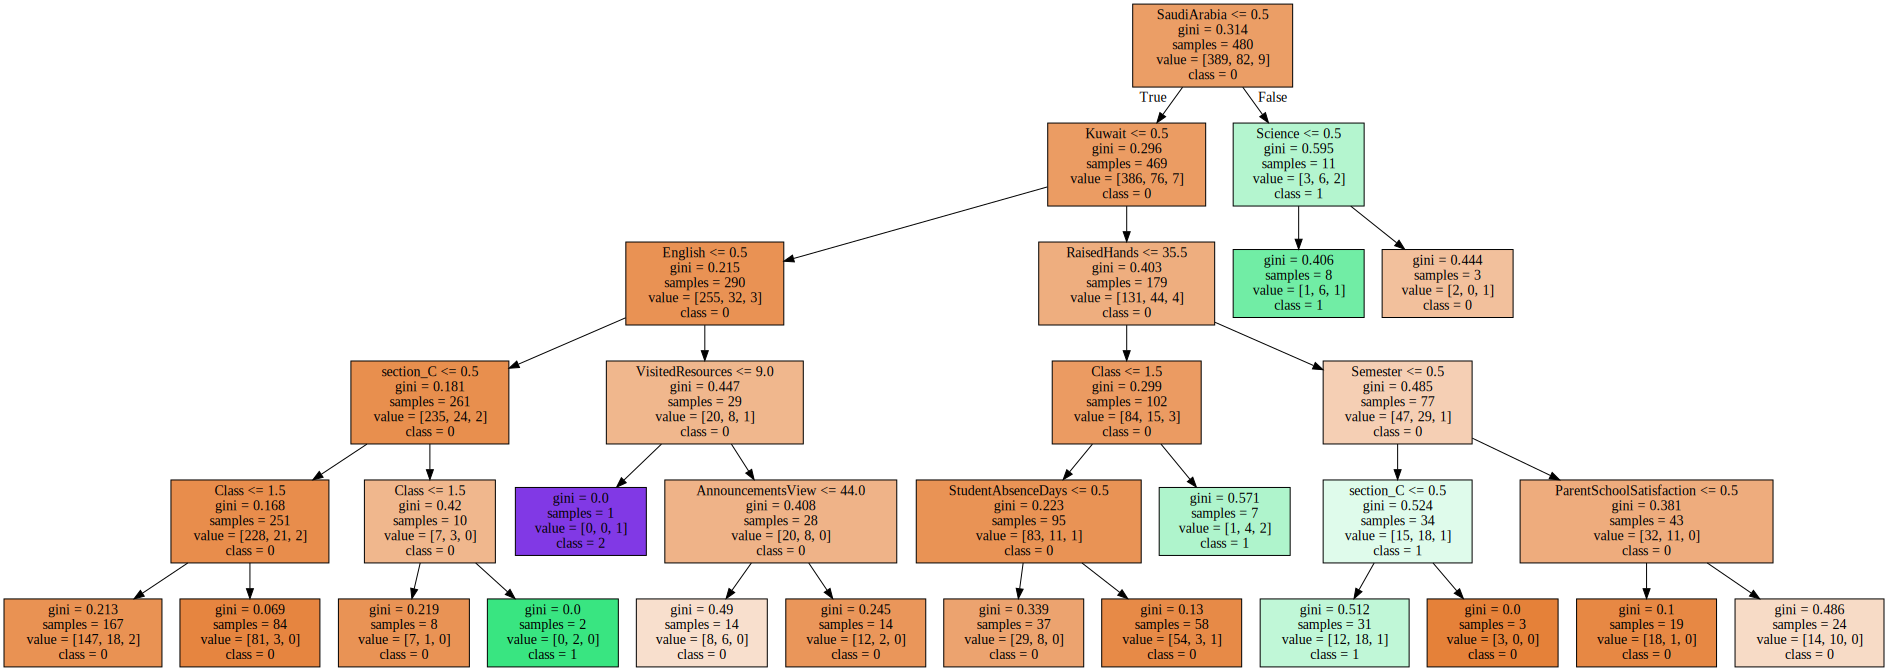

In [98]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

labels = df_clean.columns.tolist()

graph = Source(export_graphviz(vola_smote_dt,
                               out_file=None,
                               feature_names=labels,
                               class_names=['0', '1', '2', '3'],
                               filled = True))
display(SVG(graph.pipe(format='svg')))

In [112]:
from sklearn.tree import export_graphviz
import pydotplus
import collections

labels = df_clean.columns.tolist()

dot_data = export_graphviz(vola_smote_dt,
                                feature_names=labels,
                                out_file=None,
                                class_names=['0', '1', '2', '3'],
                                filled=True,
                                rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data)
nodes = graph.get_node_list()

colors = ('lightblue', 'red', 'mediumpurple', 'lightseagreen')
edges = collections.defaultdict(list)

for node in nodes:
    if node.get_name() not in ('node', 'edge'):
        values = vola_smote_dt.tree_.value[int(node.get_name())][0]
        #color only nodes where only one class is present
        #if max(values) == sum(values):    
        node.set_fillcolor(colors[np.argmax(values)])
        #mixed nodes get the default color
        #else:
        #    node.set_fillcolor(colors[-1])

graph.write_pdf('../MRes/images/tree.pdf')

True

### Undersampling decision tree

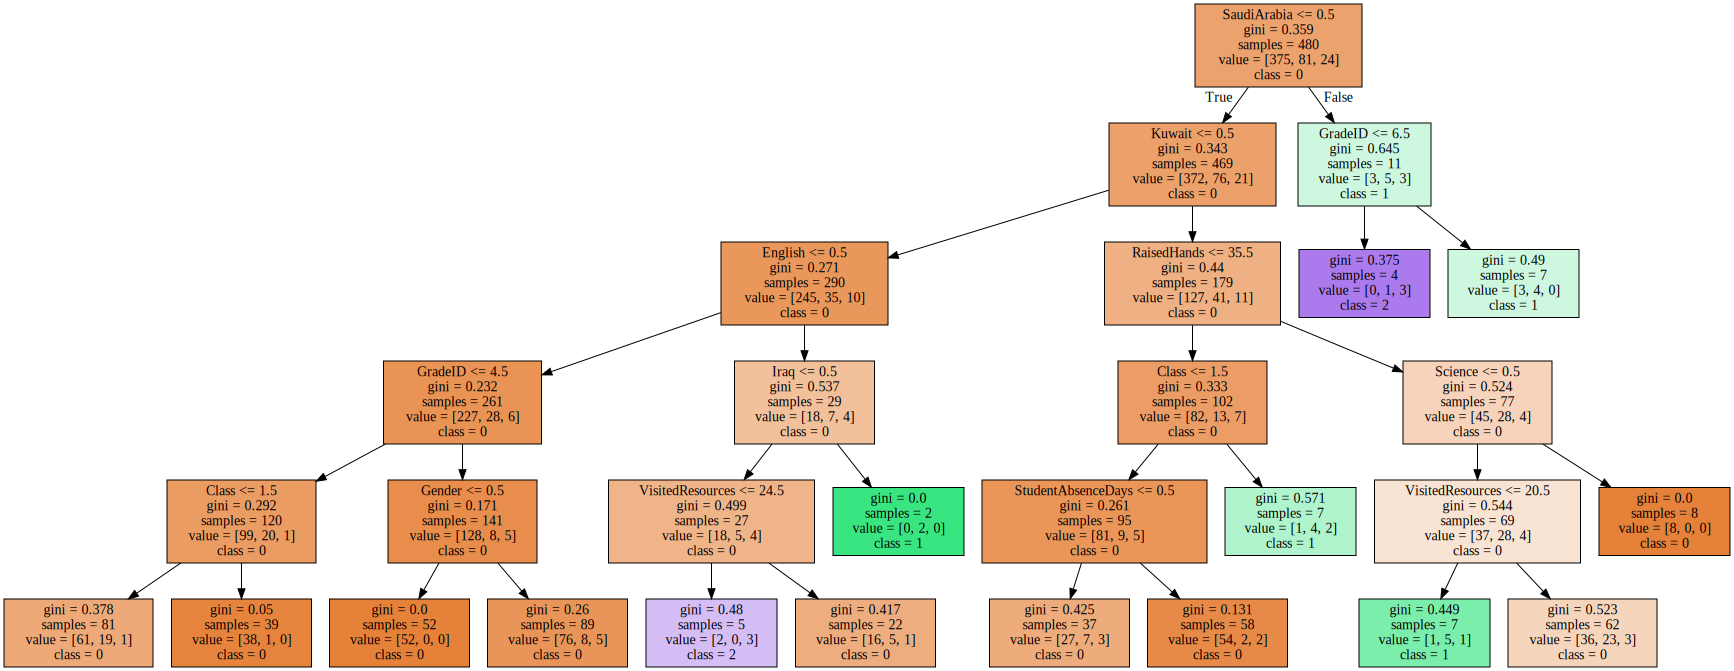

In [138]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

labels = df_clean.columns.tolist()

graph = Source(export_graphviz(vola_under_dt,
                               out_file=None,
                               feature_names=labels,
                               class_names=['0', '1', '2', '3'],
                               filled = True))
display(SVG(graph.pipe(format='svg')))

In [139]:
export_graphviz(vola_smote_dt,
                impurity=False,
                filled=True,
                feature_names=labels,
                class_names=['0', '1', '2', '3'],
                out_file='../MRes/images/smoteDT.dot')

In [140]:
export_graphviz(vola_under_dt,
                impurity=False,
                filled=True,
                feature_names=labels,
                class_names=['0', '1', '2', '3'],
                out_file='../MRes/images/underDT.dot')

In [93]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
y_pred = lof.fit_predict(X)
X_scores = lof.negative_outlier_factor_

In [94]:
df['lof_pred'] = y_pred

In [95]:
df['lof_pred'].value_counts()

 1    431
-1     49
Name: lof_pred, dtype: int64

In [96]:
df.to_csv('../Datasets/academic_all_preds_nnew.csv', index=False)

# Plots

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("whitegrid")


df = pd.read_csv('../Datasets/academic_all_preds_new.csv', header=0)

df = df.replace({'Class': {0: 'Low', 1: 'Mid', 2: 'High'},
                 'Relation': {0: 'Mother', 1: 'Father'},
                 'Gender': {0: 'Female', 1: 'Male'}})

df1 = pd.read_csv('../Datasets/originalClean.csv', header=0)
df1 = df1.replace({'Class': {'L': 'Low', 'M': 'Mid', 'H': 'High'}})

zero = df.loc[df.cat_under == 0]
one = df.loc[df.cat_under == 1]
two = df.loc[df.cat_under == 2]


# Blue, purple, red colors
ncl2 = ["#336184", "#e1485d"]
ncl3 = ["#336184", "#8a5571", "#e1485d"]
ncl4 = ["#336184", "#8a5571", "#e1485d", "#3D998E"] 

# All blue colors
#ncl4 = ["#003a65", "#557c98", "#aabdcc", "#ffffff"]
#ncl3 = ["#003a65", "#557c98", "#aabdcc"]
#ncl2 = ["#003a65", "#557c98"]

nclTrue = ["#003A65", "#D91A35"]

sns.set_palette(sns.color_palette(ncl4))

c1 = sns.color_palette(ncl4)[0]
c2 = sns.color_palette(ncl4)[1]
c3 = sns.color_palette(ncl4)[2]
c4 = sns.color_palette(ncl4)[3]

rc1 = sns.color_palette(nclTrue)[0]
rc2 = sns.color_palette(nclTrue)[1]

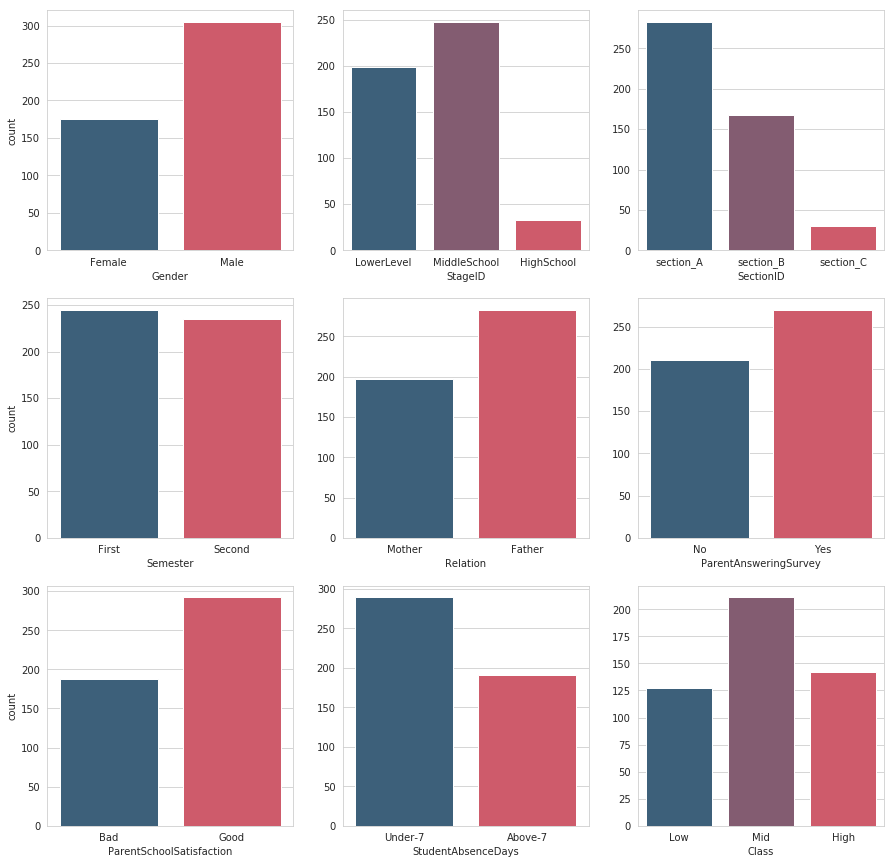

In [2]:
f, axes = plt.subplots(3, 3, figsize=(15, 15))
sns.set_palette(sns.color_palette(ncl2))
sns.countplot(x="Gender", data=df1, order=['Female', 'Male'], ax=axes[0, 0])
sns.set_palette(sns.color_palette(ncl3))
sns.countplot(x="StageID", data=df1, ax=axes[0, 1])
axes[0, 1].set_ylabel('')
sns.countplot(x="SectionID", data=df1, ax=axes[0, 2])
axes[0, 2].set_ylabel('')
sns.set_palette(sns.color_palette(ncl2))
sns.countplot(x="Semester", data=df1, ax=axes[1, 0])
sns.countplot(x="Relation", data=df1, order=['Mother', 'Father'], ax=axes[1, 1])
axes[1, 1].set_ylabel('')
sns.countplot(x="ParentAnsweringSurvey", data=df1, order=['No', 'Yes'], ax=axes[1, 2])
axes[1, 2].set_ylabel('')
sns.countplot(x="ParentSchoolSatisfaction", data=df1, order=['Bad', 'Good'], ax=axes[2, 0])
sns.countplot(x="StudentAbsenceDays", data=df1, ax=axes[2, 1])
axes[2, 1].set_ylabel('')
sns.set_palette(sns.color_palette(ncl3))
sns.countplot(x="Class", data=df1, order=['Low', 'Mid', 'High'], ax=axes[2, 2])
axes[2, 2].set_ylabel('')

plt.savefig('../MRes/images/histograms.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

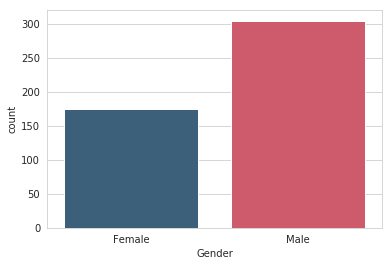

In [3]:
sns.set_palette(sns.color_palette(ncl2))
sns.countplot(x='Gender', data=df1, order=['Female', 'Male'])
plt.savefig('../MRes/images/genderCount.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

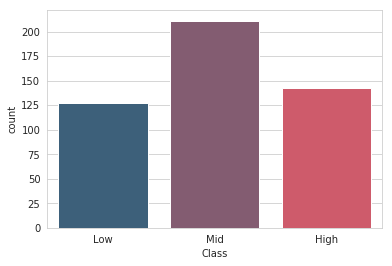

In [4]:
sns.set_palette(sns.color_palette(ncl3))
sns.countplot(x='Class', data=df1, order=['Low', 'Mid', 'High'])
plt.savefig('../MRes/images/classCount.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

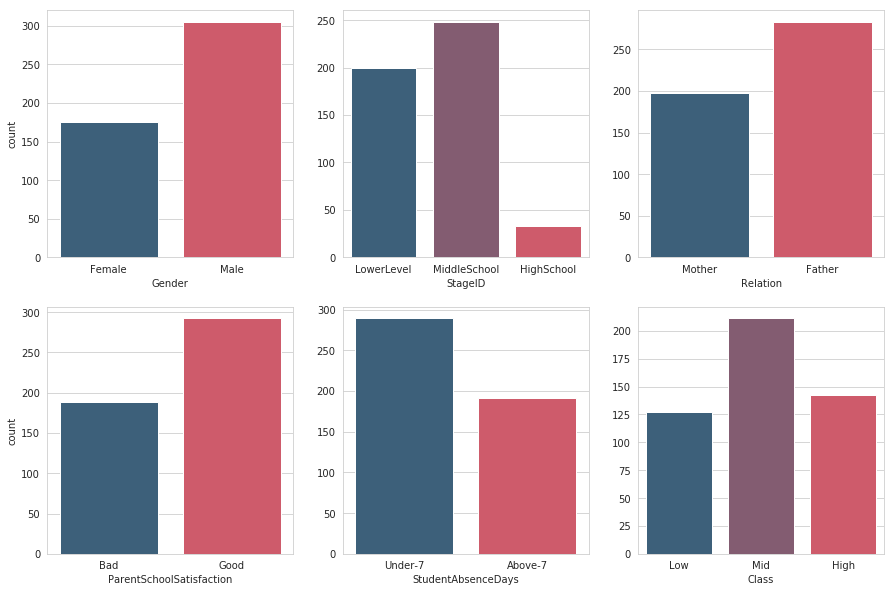

In [5]:
f, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.set_palette(sns.color_palette(ncl2))
sns.countplot(x="Gender", data=df1, order=['Female', 'Male'], ax=axes[0, 0])
sns.set_palette(sns.color_palette(ncl3))
sns.countplot(x="StageID", data=df1, ax=axes[0, 1])
axes[0, 1].set_ylabel('')
sns.set_palette(sns.color_palette(ncl2))
sns.countplot(x="Relation", data=df1, order=['Mother', 'Father'], ax=axes[0, 2])
axes[0, 2].set_ylabel('')
sns.countplot(x="ParentSchoolSatisfaction", data=df1, order=['Bad', 'Good'], ax=axes[1, 0])
sns.countplot(x="StudentAbsenceDays", data=df1, ax=axes[1, 1])
axes[1, 1].set_ylabel('')
sns.set_palette(sns.color_palette(ncl3))
sns.countplot(x="Class", data=df1, order=['Low', 'Mid', 'High'], ax=axes[1, 2])
axes[1, 2].set_ylabel('')

plt.savefig('../MRes/images/presCounts.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

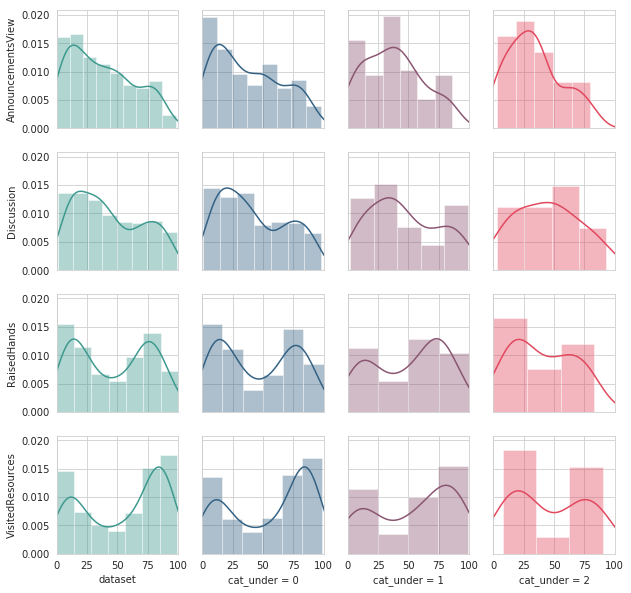

In [8]:
f, axes = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)

sns.distplot(df["AnnouncementsView"], ax=axes[0, 0], color=c4, axlabel='')
axes[0, 0].set_ylabel('AnnouncementsView')
sns.distplot(zero["AnnouncementsView"], ax=axes[0, 1], color=c1, axlabel='')
sns.distplot(one["AnnouncementsView"], ax=axes[0, 2], color=c2, axlabel='')
sns.distplot(two["AnnouncementsView"], ax=axes[0, 3], color=c3, axlabel='')

sns.distplot(df["Discussion"], ax=axes[1, 0], color=c4, axlabel='')
axes[1, 0].set_ylabel('Discussion')
sns.distplot(zero["Discussion"], ax=axes[1, 1], color=c1, axlabel='')
sns.distplot(one["Discussion"], ax=axes[1, 2], color=c2, axlabel='')
sns.distplot(two["Discussion"], ax=axes[1, 3], color=c3, axlabel='')

sns.distplot(df["RaisedHands"], ax=axes[2, 0], color=c4, axlabel='')
axes[2, 0].set_ylabel('RaisedHands')
sns.distplot(zero["RaisedHands"], ax=axes[2, 1], color=c1, axlabel='')
sns.distplot(one["RaisedHands"], ax=axes[2, 2], color=c2, axlabel='')
sns.distplot(two["RaisedHands"], ax=axes[2, 3], color=c3, axlabel='')

sns.distplot(df["VisitedResources"], ax=axes[3, 0], color=c4, axlabel='dataset')
axes[3, 0].set_ylabel('VisitedResources')
sns.distplot(zero["VisitedResources"], ax=axes[3, 1], color=c1, axlabel='cat_under = 0')
sns.distplot(one["VisitedResources"], ax=axes[3, 2], color=c2, axlabel='cat_under = 1')
sns.distplot(two["VisitedResources"], ax=axes[3, 3], color=c3, axlabel='cat_under = 2')

plt.xlim(0,100)
#plt.savefig('../MRes/images/catHist.pdf',
#            bbox_inches="tight", pad_inches=0)
plt.show()

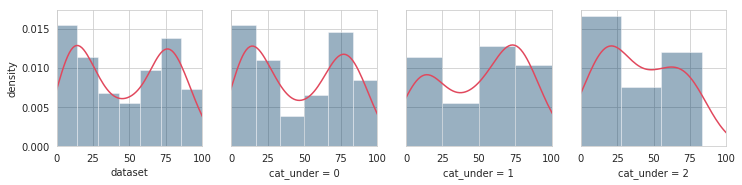

In [9]:
f, axes = plt.subplots(ncols=4, figsize=(12, 2.5), sharex=True, sharey=True)

sns.distplot(df["RaisedHands"], ax=axes[0], color=rc1, axlabel='dataset', kde_kws={"color": c3})
axes[0].set_ylabel('density')
sns.distplot(zero["RaisedHands"], ax=axes[1], color=rc1, axlabel='cat_under = 0', kde_kws={"color": c3})
sns.distplot(one["RaisedHands"], ax=axes[2], color=rc1, axlabel='cat_under = 1', kde_kws={"color": c3})
sns.distplot(two["RaisedHands"], ax=axes[3], color=rc1, axlabel='cat_under = 2', kde_kws={"color": c3})

plt.xlim(0,100)
plt.savefig('../MRes/images/raisedHist.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

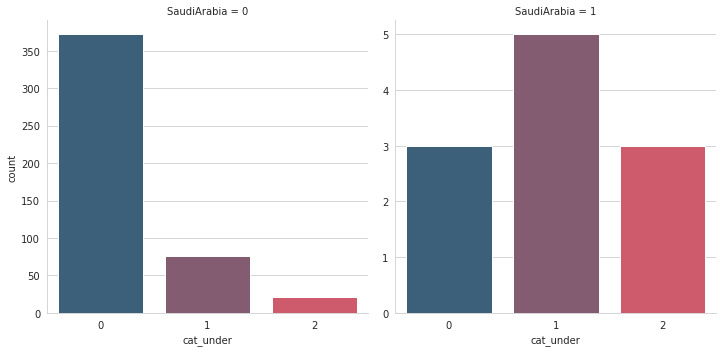

In [10]:
sns.set_palette(sns.color_palette(ncl3))
sns.catplot(data=df, x="cat_under", col="SaudiArabia", kind="count",
            sharey=False)
#plt.savefig('../MRes/images/saudiCat.pdf',
#            bbox_inches="tight", pad_inches=0)
plt.show()

as expected, volatility is very different in saudi as compared to the rest

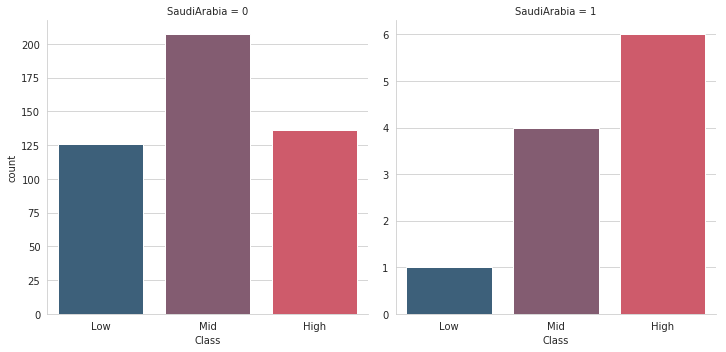

In [11]:
sns.catplot(data=df, x="Class", col="SaudiArabia", kind="count",
            sharey=False, order=['Low', 'Mid', 'High'])
plt.savefig('../MRes/images/saudiClass.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

Saudi also has very different distribution of classes, with most of their student being class 2!

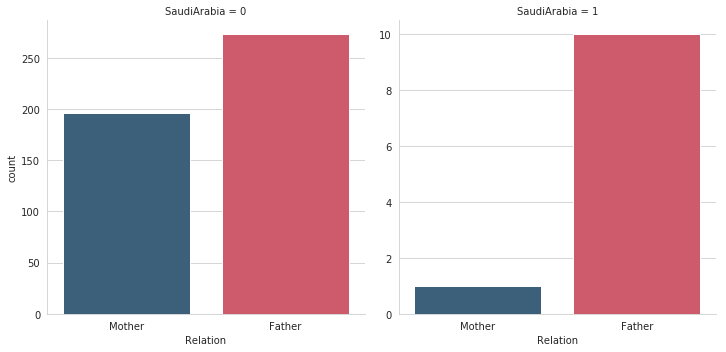

In [12]:
sns.set_palette(sns.color_palette(ncl2))
sns.catplot(data=df, x="Relation", col="SaudiArabia", kind="count",
            sharey=False, order=['Mother', 'Father'])
plt.savefig('../MRes/images/saudiRelation.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

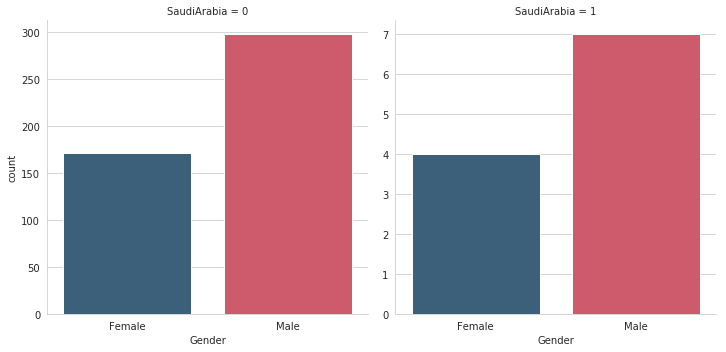

In [13]:
sns.catplot(data=df, x="Gender", col="SaudiArabia", kind="count",
            sharey=False, order=['Female', 'Male'])
plt.savefig('../MRes/images/saudiGender.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

SaudiArabia has a VERY different Mother/Father ratio in who looks after child's school

In [14]:
df3 = df[['Class',
          'AnnouncementsView',
          'Discussion',
          'RaisedHands',
          'VisitedResources']]

df3 = pd.melt(df3,
              id_vars=['Class'],
              value_vars=['AnnouncementsView', 'Discussion', 'RaisedHands', 'VisitedResources'])

df3 = df3.rename(index=str, columns={"value": "count"})

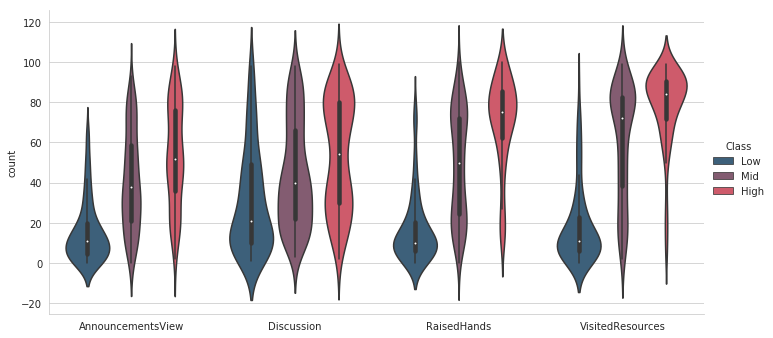

In [15]:
sns.set_palette(sns.color_palette(ncl3))
ax = sns.catplot(x="variable", y="count", hue="Class",
            kind="violin", data=df3, aspect=2, hue_order=['Low', 'Mid', 'High'])
ax.set(xlabel='')

plt.savefig('../MRes/images/classViolin.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

Violin plots show how classes have very different distributions along numerical variables, mention right/left skewed

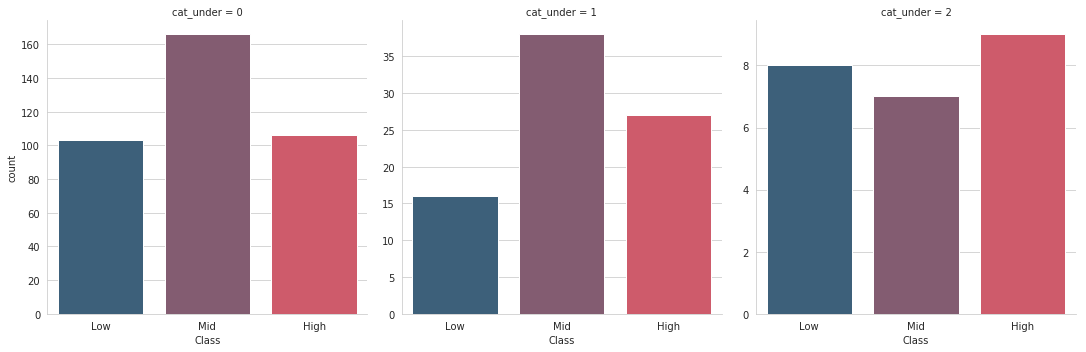

In [16]:
sns.catplot(data=df, x="Class", col="cat_under", kind="count", sharey=False, order=['Low', 'Mid', 'High'])
plt.savefig('../MRes/images/catClass.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

The ratio between Class 0 & Class 2 changes when moving away from vola 0 to vola 2. Class 2 is much more likely in vola=2

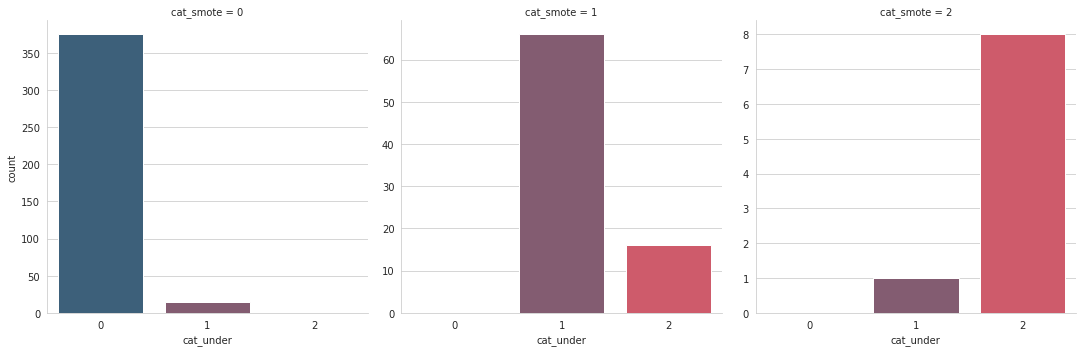

In [121]:
sns.catplot(data=df, x="cat_under", col="cat_smote", kind="count", sharey=False)
#plt.savefig('../MRes/images/catUnder.pdf',
#            bbox_inches="tight", pad_inches=0)
plt.show()

small discrepancies in under vs smote volatilities

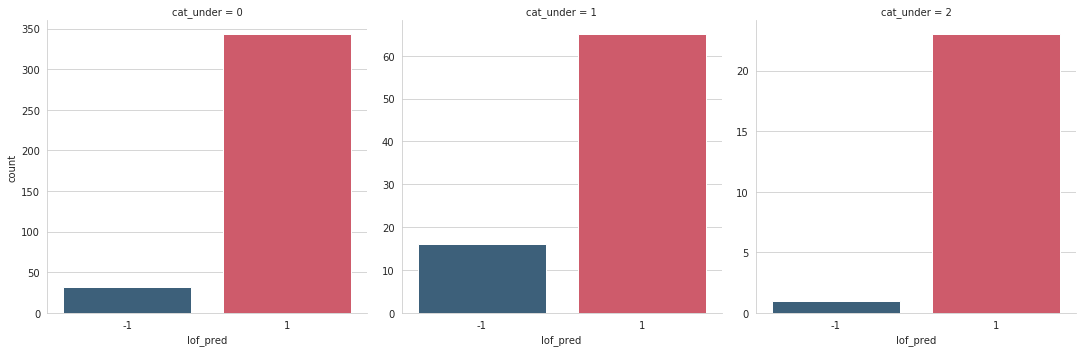

In [17]:
sns.set_palette(sns.color_palette(ncl2))
sns.catplot(data=df, x="lof_pred", col="cat_under", kind="count", sharey=False)
#plt.savefig('../MRes/images/catLOF.pdf',
#            bbox_inches="tight", pad_inches=0)
plt.show()

very small discrepancies with lof_pred per volatility. If anything, a little bit more outliers on the 2 category

## Contingency tables / Chi-sq test for check correlation between lof and cat. volatility

In [9]:
pd.crosstab(df['cat_smote'],
            df['lof_pred'],
            rownames=['cat_smote'],
            colnames=['lof_pred'],
            normalize='index').round(2)

lof_pred,-1,1
cat_smote,,
0,0.09,0.91
1,0.15,0.85
2,0.11,0.89


In [22]:
pd.crosstab(df['cat_smote'],
            df['Class'],
            rownames=['cat_smote'],
            colnames=['Class'],
            normalize='index').round(2)

Class,High,Low,Mid
cat_smote,,,
0,0.28,0.28,0.43
1,0.35,0.18,0.46
2,0.33,0.22,0.44


## Confusion matrices for Class

In [14]:
pd.crosstab(df.Class, df.base, norma)

base,0.0,1.0,2.0
Class,,,
High,0,31,111
Low,110,17,0
Mid,17,169,25


In [45]:
pd.crosstab(df.loc[df.SaudiArabia == 1].Class, df.loc[df.SaudiArabia == 1].base, normalize='index').round(2)

base,0.0,1.0,2.0
Class,,,
High,0.00,0.83,0.17
Low,0.00,1.00,0.00
Mid,0.25,0.50,0.25


In [46]:
pd.crosstab(df.loc[df.SaudiArabia == 1].Class, df.loc[df.SaudiArabia == 1].smote, normalize='index').round(2)

smote,0.0,1.0,2.0
Class,,,
High,0.0,0.17,0.83
Low,1.0,0.00,0.00
Mid,0.0,0.75,0.25


In [47]:
pd.crosstab(df.loc[df.SaudiArabia == 1].Class, df.loc[df.SaudiArabia == 1].under, normalize='index').round(2)

under,0.0,1.0,2.0
Class,,,
High,0.0,0.33,0.67
Low,1.0,0.00,0.00
Mid,0.0,0.75,0.25


In [36]:
pd.crosstab(df.loc[df.SaudiArabia == 1].Class, df.loc[df.SaudiArabia == 1].smote)

smote,0.0,1.0,2.0
Class,,,
High,0,1,5
Low,1,0,0
Mid,0,3,1


In [18]:
pd.crosstab(df.loc[df.Gender == 'Male'].Class, df.loc[df.Gender == 'Male'].base)

base,0.0,1.0,2.0
Class,,,
High,0,20,47
Low,89,14,0
Mid,12,114,9


In [23]:
pd.crosstab(df.loc[df.Gender == 'Female'].Class, df.loc[df.Gender == 'Female'].base, normalize='index').round(2)

base,0.0,1.0,2.0
Class,,,
High,0.00,0.15,0.85
Low,0.88,0.12,0.00
Mid,0.07,0.72,0.21


In [24]:
pd.crosstab(df.loc[df.Gender == 'Female'].Class, df.loc[df.Gender == 'Female'].smote, normalize='index').round(2)

smote,0.0,1.0,2.0
Class,,,
High,0.0,0.04,0.96
Low,1.0,0.00,0.00
Mid,0.0,0.97,0.03


In [28]:
pd.crosstab(df.loc[df.Gender == 'Female'].Class, df.loc[df.Gender == 'Female'].under, normalize='index').round(2)

under,0.0,1.0,2.0
Class,,,
High,0.0,0.04,0.96
Low,1.0,0.00,0.00
Mid,0.0,0.99,0.01


In [7]:
pd.crosstab(df.Class, df.cat_smote)

cat_smote,0,1,2
Class,,,
High,110,29,3
Low,110,15,2
Mid,169,38,4


In [56]:
pd.crosstab(df['lof_pred'],
            df['cat_under'],
            rownames=['lof_pred'],
            colnames=['cat_under'])

cat_under,0,1,2
lof_pred,,,
-1,32,16,1
1,343,65,23


In [11]:
pd.crosstab(df['cat_smote'],
            df['cat_under'],
            colnames=['cat_under'],
            rownames=['cat_smote'],
            normalize='index').round(2)

cat_under,0,1,2
cat_smote,,,
0,0.96,0.04,0.00
1,0.00,0.80,0.20
2,0.00,0.11,0.89


In [18]:
from scipy.stats import chi2_contingency

chi2_contingency(pd.crosstab(df['lof_pred'], df['cat_under']))

(10.154049802442247,
 0.006238441413848307,
 2,
 array([[ 38.28125,   8.26875,   2.45   ],
        [336.71875,  72.73125,  21.55   ]]))

In [19]:
dfsel = df.loc[df.cat_smote != 2]
chi2_contingency(pd.crosstab(dfsel['Class'], dfsel['cat_under']))

(4.576904116220067,
 0.333525784054961,
 4,
 array([[110.66878981,  23.60934183,   4.72186837],
        [ 99.52229299,  21.23142251,   4.2462845 ],
        [164.8089172 ,  35.15923567,   7.03184713]]))

In [60]:
chi2_contingency(pd.crosstab(df['lof_pred'], df['cat_under']))

(10.154049802442247,
 0.006238441413848307,
 2,
 array([[ 38.28125,   8.26875,   2.45   ],
        [336.71875,  72.73125,  21.55   ]]))

In [62]:
chi2_contingency(pd.crosstab(df['cat_smote'], df['cat_under']))

(505.82718010365863,
 3.678827193692247e-108,
 4,
 array([[303.90625,  65.64375,  19.45   ],
        [ 64.0625 ,  13.8375 ,   4.1    ],
        [  7.03125,   1.51875,   0.45   ]]))

In [64]:
chi2_contingency(pd.crosstab(df['Class'], df['cat_smote']))

(3.937714166496092,
 0.4145009448354867,
 4,
 array([[115.07916667,  24.25833333,   2.6625    ],
        [102.92291667,  21.69583333,   2.38125   ],
        [170.99791667,  36.04583333,   3.95625   ]]))

In [20]:
chi2_contingency(pd.crosstab(df['Class'], df['cat_under']))

(4.426095298041464,
 0.3514008308173997,
 4,
 array([[110.9375 ,  23.9625 ,   7.1    ],
        [ 99.21875,  21.43125,   6.35   ],
        [164.84375,  35.60625,  10.55   ]]))